In [1]:
from towhee import ops, pipe, DataCollection
import numpy as np
import cv2
import csv
import pandas as pd
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

HOST = "localhost"
PORT = "19530"
COLLECTION_NAME = 'ImageCollection'
INDEX_PARAMS = {
    'metric_type': 'L2',
    'index_type': 'IVF_FLAT',
    'params': {'nlist': 4},
}
DIMESION = 512

In [3]:
connections.connect(host=HOST, port=PORT)

def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        # utility.drop_collection(collection_name)
        return Collection(name=collection_name)
    
    fields = [
        FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='text image search')
    collection = Collection(name=collection_name, schema=schema)

    collection.create_index(field_name="embedding", index_params=INDEX_PARAMS)
    return collection
    
collection = create_milvus_collection(COLLECTION_NAME, DIMESION)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


img,vec
,"[0.034783073, -0.10504085, 0.0104692625, ...] shape=(512,)"

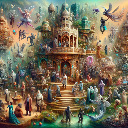

<Figure size 128x128 with 0 Axes>

In [4]:
# pipe line 基本流程

p = (
    pipe.input('path')
    .map('path', 'img', ops.image_decode.cv2('rgb'))
    .map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='image'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('img', 'vec')
)

DataCollection(p('./Dixit Card/1.png')).show()

In [6]:
# 將文字轉換成embedding

p2 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('text', 'vec')
)

DataCollection(p2("A teddybear on a skateboard in Times Square.")).show()

text,vec
A teddybear on a skateboard in Times Square.,"[-0.008685344, 0.02717691, -0.00074256025, ...] shape=(512,)"


In [7]:
def read_csv(csv_path, encoding='utf-8-sig'):
    with open(csv_path, 'r', encoding=encoding) as f:
        data = csv.DictReader(f)
        for line in data:
            yield int(line['id']), line['path']

p3 = (
    pipe.input('csv_file')
    .flat_map('csv_file', ('id', 'path'), read_csv)
    .map('path', 'img', ops.image_decode.cv2('rgb'))
    .map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='image'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map(('id', 'vec'), (), ops.ann_insert.milvus_client(host=HOST, port=PORT, collection_name=COLLECTION_NAME))
    .output()
)

ret = p3('reverse_image_search.csv')

In [5]:
collection.flush()
collection.load()
print('Total number of inserted data is {}.'.format(collection.num_entities))

KeyboardInterrupt: 

text,images,sorted_image_info
Age of Empires,,"[(34, 1.4596388339996338),(1, 1.4984791278839111),(31, 1.5243977308273315),(32, 1.5245553255081177),...] len=5"

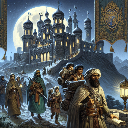
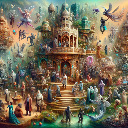
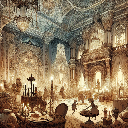
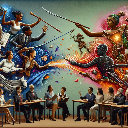
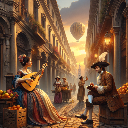

In [11]:
def read_image(image_ids):
    df = pd.read_csv('reverse_image_search.csv')
    id_img = df.set_index('id')['path'].to_dict()
    imgs = []
    decode = ops.image_decode.cv2('rgb')
    for image_id in image_ids:
        path = id_img[image_id]
        imgs.append(decode(path))
    return imgs

query = 'gorgeous, laughter, happy'
ids = [25, ]
p4 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch16', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map('vec', 'result', ops.ann_search.milvus_client(host=HOST, port=PORT, collection_name=COLLECTION_NAME, limit=5))
    .map('result', 'image_info', lambda x: [(item[0], item[1]) for item in x])
    # Optionally sort by similarity score if needed
    .map('image_info', 'sorted_image_info', lambda x: sorted(x, key=lambda item: item[1]))
    # Extract sorted image IDs
    .map('sorted_image_info', 'image_ids', lambda x: [item[0] for item in x])
    .map('image_ids', 'images', read_image)
    .output('text', 'images', 'sorted_image_info')
)

DataCollection(p4(query)).show()